(HW7)=
# HW7

**Deadline (hard only!)**: 24.04.2024 11:59 (GMT+5).

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imread
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from glob import glob
%config InlineBackend.figure_format = 'svg'

def load_notmnist(path='./notMNIST_small',letters='ABCDEFGHIJ',
                  img_shape=(28,28),test_size=0.25,one_hot=False):
    
    # download data if it's missing. If you have any problems, go to the urls and load it manually.
    if not os.path.exists(path):
        print("Downloading data...")
        assert os.system('curl http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz > notMNIST_small.tar.gz') == 0
        print("Extracting ...")
        assert os.system('tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log') == 0
    
    data,labels = [],[]
    print("Parsing...")
    for img_path in glob(os.path.join(path,'*/*')):
        class_i = img_path.split(os.sep)[-2]
        if class_i not in letters: 
            continue
        try:
            data.append(resize(imread(img_path), img_shape))
            labels.append(class_i,)
        except:
            print("found broken img: %s [it's ok if <10 images are broken]" % img_path)
        
    data = np.stack(data)[:,None].astype('float32')
    data = (data - np.mean(data)) / np.std(data)

    #convert classes to ints
    letter_to_i = {l:i for i,l in enumerate(letters)}
    labels = np.array(list(map(letter_to_i.get, labels)))
    
    if one_hot:
        labels = (np.arange(np.max(labels) + 1)[None,:] == labels[:, None]).astype('float32')
    
    #split into train/test
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, stratify=labels)
    
    print("Done")
    return X_train, y_train, X_test, y_test

## Task description

In this notebook you are suggested to train several models of machine learning on the notMNIST dataset. To get full points per each model it must beat the **baseline** on test dataset. Models to test:

* logistic regression, 86% (**1 point**)
* k-nearest neigbors, 88% (**1 point**)
* MLP, 91% (**1 point**)
* CNN, 92% (**1.5 points**)
* overall comparison of models, including some graphs (e.g, bar plot) (**0.5 points**)

### Important notes

* The total time of execution of all cells must not exceed $10$ minutes
* Broken code in a section automatically implies $0$ points for this section
* Do not erase any existing cells
* Use magic cell %%time to measure the time of execution of heavy-computation cells
* For each model use the followind structure:
    1. Import and build model

    2. Fit model on train dataset

    3. Measure and print train and test accuracy

    4. Make predictions on test dataset

    5. Plot confusion matrix

    6. Plot 16 random samples from the test dataset with true labels and predicted classes
    
    7. Try different hyperparameters, plot graphs of accuracy vs most important parameters

## Load `notmnist` dataset

In [2]:
%%time
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done
CPU times: total: 8.56 s
Wall time: 8.58 s


Size of train and test datasets:

In [3]:
X_train.shape, X_test.shape

((14043, 784), (4681, 784))

Verify that the classes are balanced:

In [4]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1404, 1405, 1405, 1405, 1404, 1404, 1404, 1404, 1404, 1404],
       dtype=int64))

## Visualize some data

In [5]:
def plot_letters(X, y_true, y_pred=None, n=4, random_state=123):
    np.random.seed(random_state)
    indices = np.random.choice(np.arange(X.shape[0]), size=n*n, replace=False)
    plt.figure(figsize=(10, 10))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[indices[i]].reshape(28, 28), cmap='gray')
        # plt.imshow(train_images[i], cmap=plt.cm.binary)
        if y_pred is None:
            title = chr(ord("A") + y_true[indices[i]])
        else:
            title = f"y={chr(ord('A') + y_true[indices[i]])}, ŷ={chr(ord('A') + y_pred[indices[i]])}"
        plt.title(title, size=20)
    plt.show()

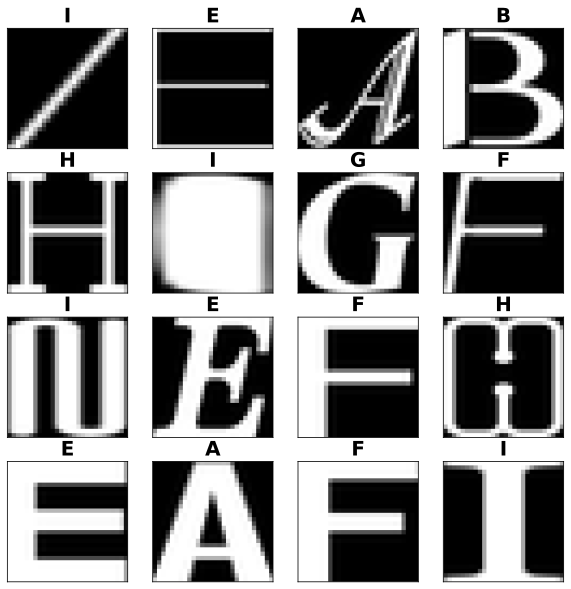

In [6]:
plot_letters(X_train, y_train, random_state=912)

## Logistic regression

**Hyperparameters**:
* regularization type (`penalty`)
* regularization constant ($C$)
* `max_iter`

In [50]:
%%time
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter=8000, C=0.001)
model_lr.fit(X_train, y_train)
predictions_lr = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, predictions_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr:.2%}')



Logistic Regression Accuracy: 88.44%
CPU times: total: 18.4 s
Wall time: 3.39 s


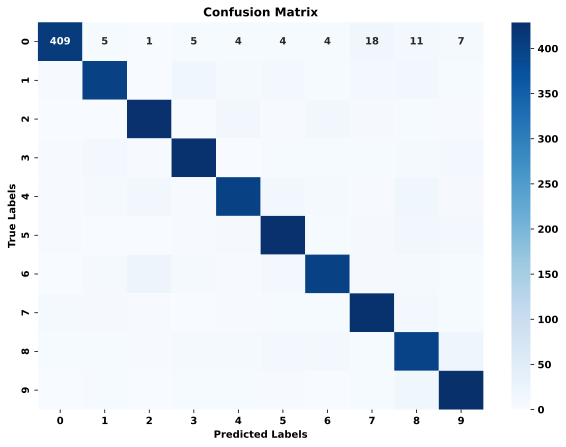

CPU times: total: 297 ms
Wall time: 281 ms


In [59]:
%%time
cm = confusion_matrix(y_test, predictions_lr)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


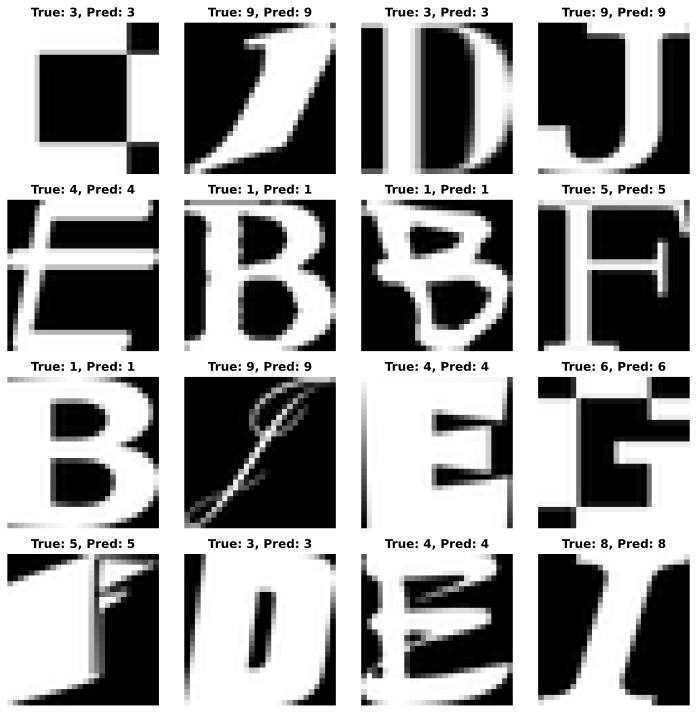

CPU times: total: 1.23 s
Wall time: 1.59 s


In [60]:
%%time
def plot_random_samples(X, y_true, y_pred, num_samples=16):
    indices = np.random.choice(np.arange(len(X)), num_samples, replace=False)
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(indices):
        plt.subplot(4, 4, i + 1)
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')
        plt.title(f'True: {y_true[idx]}, Pred: {y_pred[idx]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_random_samples(X_test, y_test, predictions_lr)


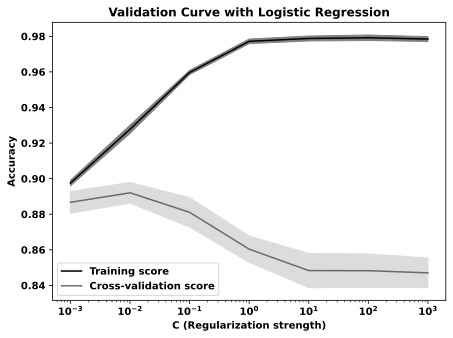

CPU times: total: 812 ms
Wall time: 44 s


In [58]:
%%time
from sklearn.model_selection import validation_curve

param_range = np.logspace(-3, 3, 7)
train_scores, test_scores = validation_curve(
    LogisticRegression(), X_train, y_train, param_name="C", param_range=param_range,
    scoring="accuracy", n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
plt.title("Validation Curve with Logistic Regression")
plt.xlabel("C (Regularization strength)")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc="best")
plt.xscale('log')
plt.show()


## kNN

**Hyperparameters**:
* `n_neigbors`
* `metric`

In [64]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_flat, y_train)
predictions_knn = knn.predict(X_test_flat)
accuracy_knn = accuracy_score(y_test, predictions_knn)
print(f'kNN Accuracy: {accuracy_knn:.2%}')




kNN Accuracy: 88.34%
CPU times: total: 6.86 s
Wall time: 1.25 s


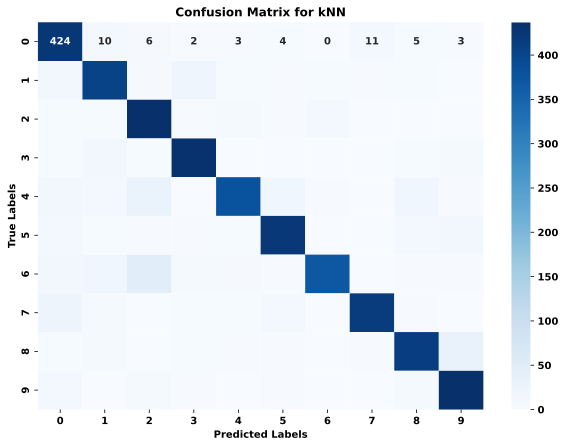

In [65]:
cm = confusion_matrix(y_test, predictions_knn)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for kNN')
plt.show()

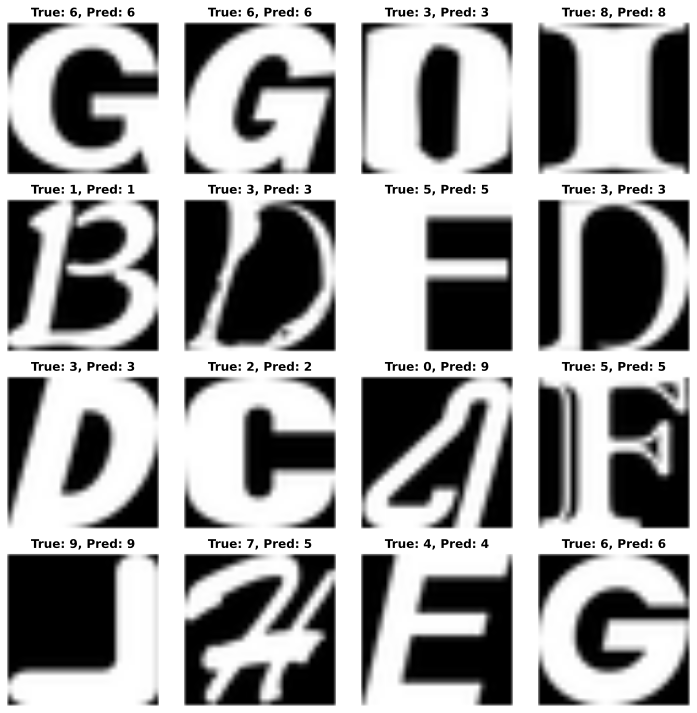

In [66]:
%%time

def plot_sample_images(X, y_true, y_pred, sample_size=16, img_shape=(28, 28)):
    indices = np.random.choice(np.arange(len(X)), sample_size, replace=False)
    plt.figure(figsize=(10, 10))
    for i, index in enumerate(indices):
        plt.subplot(4, 4, i + 1)
        plt.imshow(X[index].reshape(img_shape), cmap='gray', interpolation='none')
        plt.title(f'True: {y_true[index]}, Pred: {y_pred[index]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(X_test, y_test, predictions_knn)


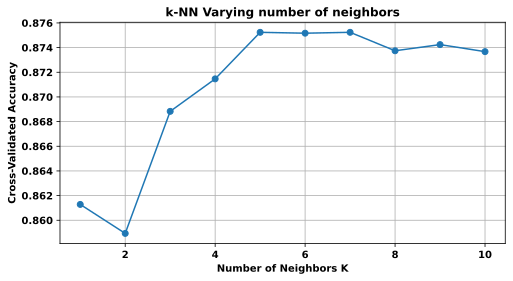

In [67]:
%%time
from sklearn.model_selection import cross_val_score

neighbors_range = range(1, 11)
accuracy_scores = []

for k in neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_flat, y_train, cv=5, scoring='accuracy')
    accuracy_scores.append(scores.mean())

plt.figure(figsize=(8, 4))
plt.plot(neighbors_range, accuracy_scores, marker='o')
plt.title('k-NN Varying number of neighbors')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.show()


## MLP

**Hyperparameters**:
* number of layers
* width of layers
* activation function

In [68]:
%%time
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, activation='relu', solver='adam')
mlp.fit(X_train_flat, y_train)

predictions_mlp = mlp.predict(X_test_flat)

accuracy_mlp = accuracy_score(y_test, predictions_mlp)
print(f'MLP Accuracy: {accuracy_mlp:.2%}')


MLP Accuracy: 91.60%
CPU times: total: 50.2 s
Wall time: 8.84 s


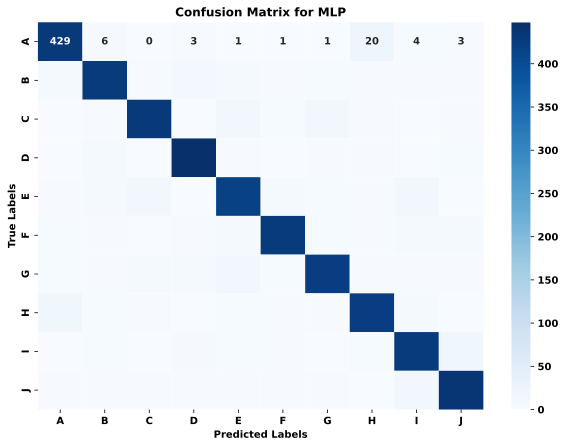

CPU times: total: 266 ms
Wall time: 274 ms


In [71]:
%%time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, predictions_mlp)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'], yticklabels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.title('Confusion Matrix for MLP')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


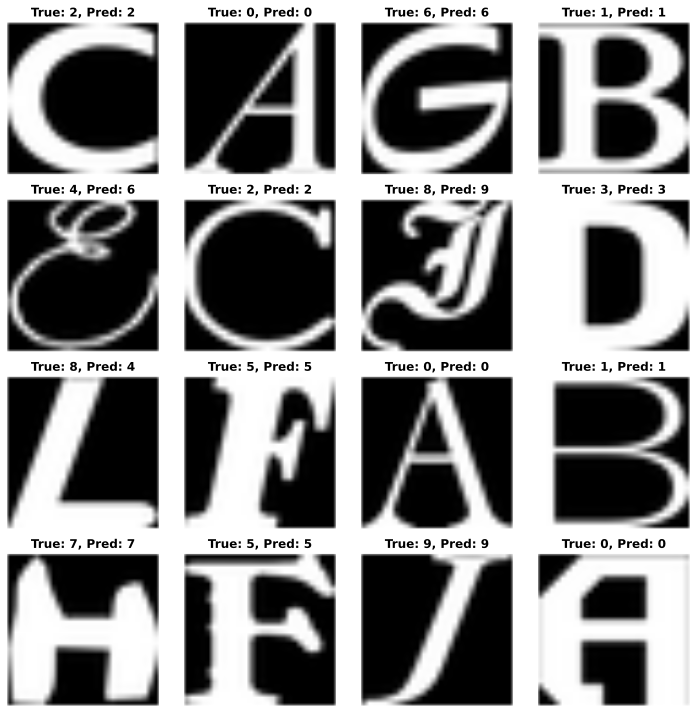

CPU times: total: 750 ms
Wall time: 746 ms


In [69]:
%%time
def plot_sample_images(X, y_true, y_pred, sample_size=16, img_shape=(28, 28)):
    indices = np.random.choice(np.arange(len(X)), sample_size, replace=False)
    plt.figure(figsize=(10, 10))
    for i, index in enumerate(indices):
        plt.subplot(4, 4, i + 1)
        plt.imshow(X[index].reshape(img_shape), cmap='gray', interpolation='none')
        plt.title(f'True: {y_true[index]}, Pred: {y_pred[index]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(X_test_flat, y_test, predictions_mlp)


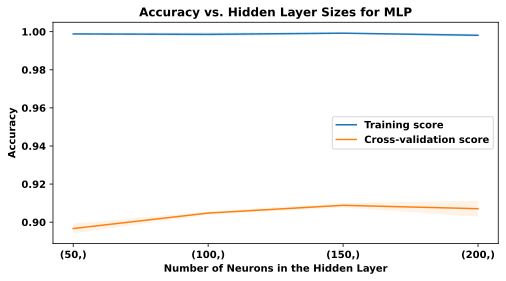

CPU times: total: 266 ms
Wall time: 53.3 s


In [70]:
%%time
from sklearn.model_selection import validation_curve

hidden_layer_sizes = [(50,), (100,), (150,), (200,)]
train_scores, test_scores = validation_curve(
    MLPClassifier(max_iter=300), X_train_flat, y_train, param_name="hidden_layer_sizes",
    param_range=hidden_layer_sizes, cv=3, scoring="accuracy", n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.plot([str(x) for x in hidden_layer_sizes], train_mean, label='Training score')
plt.plot([str(x) for x in hidden_layer_sizes], test_mean, label='Cross-validation score')
plt.fill_between([str(x) for x in hidden_layer_sizes], train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between([str(x) for x in hidden_layer_sizes], test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title('Accuracy vs. Hidden Layer Sizes for MLP')
plt.xlabel('Number of Neurons in the Hidden Layer')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()


## CNN

**Hyperparameters**:
* number of convolutional layers
* number of dense layers
* activation function

## Plot results